# Image Classification: Logistic Regression & K-Means
## Malaria Cell Images Dataset (Parasitized vs Uninfected)

In [55]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import cv2
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## 1. Load and Preprocess the Dataset

In [56]:
# Define paths
data_path = 'data/cell_images/'
classes = ['Parasitized', 'Uninfected']

# Image size for resizing
IMG_SIZE = 64

# Image preprocessing function
def preprocess_image(img):
    """
    Apply preprocessing techniques to enhance image quality:
    1. CLAHE (Contrast Limited Adaptive Histogram Equalization) - enhances contrast
    2. Gaussian blur - reduces noise
    """
    # Convert RGB to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE on L-channel (lightness) for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_enhanced = clahe.apply(l)
    
    # Merge channels and convert back to RGB
    lab_enhanced = cv2.merge((l_enhanced, a, b))
    img_enhanced = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2RGB)
    
    # Apply light Gaussian blur to reduce noise
    img_processed = cv2.GaussianBlur(img_enhanced, (3, 3), 0)
    
    return img_processed

# Function to load images
def load_images(data_path, classes, img_size=64, max_images_per_class=2000):
    images = []
    labels = []
    
    for idx, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        image_files = os.listdir(class_path)[:max_images_per_class]
        
        print(f"Loading {len(image_files)} images from {class_name}...")
        
        for img_name in tqdm(image_files):
            img_path = os.path.join(class_path, img_name)
            try:
                # Read image
                img = cv2.imread(img_path)
                # Resize image
                img = cv2.resize(img, (img_size, img_size))
                # Convert to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Apply preprocessing
                img = preprocess_image(img)
                images.append(img)
                labels.append(idx)
            except:
                continue
    
    return np.array(images), np.array(labels)

# Load images
X, y = load_images(data_path, classes, IMG_SIZE, max_images_per_class=13000)
print(f"\nDataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

Loading 2000 images from Parasitized...


100%|██████████| 2000/2000 [00:01<00:00, 1178.77it/s]


Loading 2000 images from Uninfected...


100%|██████████| 2000/2000 [00:01<00:00, 1248.95it/s]


Dataset shape: (4000, 64, 64, 3)
Labels shape: (4000,)
Class distribution: [2000 2000]


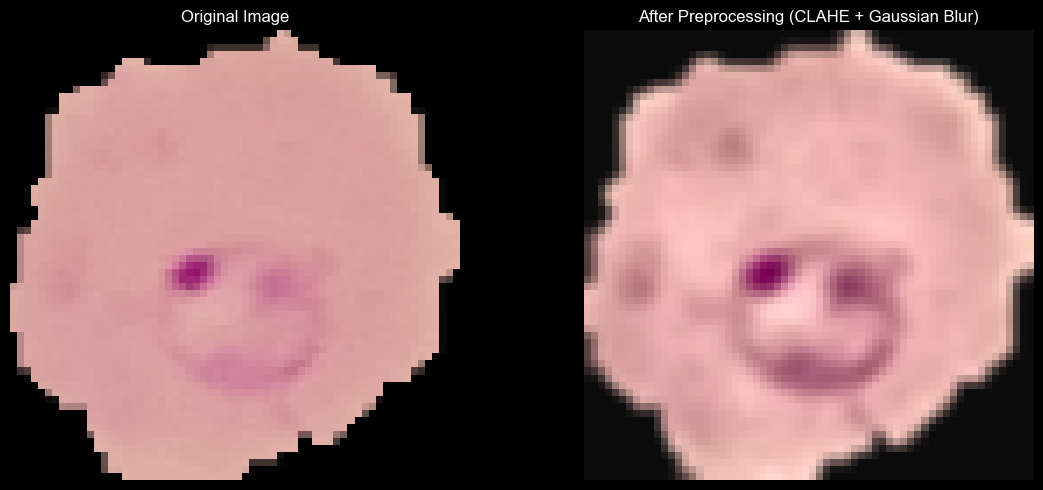

In [57]:
# Visualize preprocessing effects (before vs after)
# Load a sample image without preprocessing for comparison
sample_img_path = os.path.join(data_path, classes[0], os.listdir(os.path.join(data_path, classes[0]))[0])
sample_original = cv2.imread(sample_img_path)
sample_original = cv2.resize(sample_original, (IMG_SIZE, IMG_SIZE))
sample_original = cv2.cvtColor(sample_original, cv2.COLOR_BGR2RGB)
sample_processed = preprocess_image(sample_original)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(sample_original)
axes[0].set_title('Original Image', fontsize=12)
axes[0].axis('off')

axes[1].imshow(sample_processed)
axes[1].set_title('After Preprocessing (CLAHE + Gaussian Blur)', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()


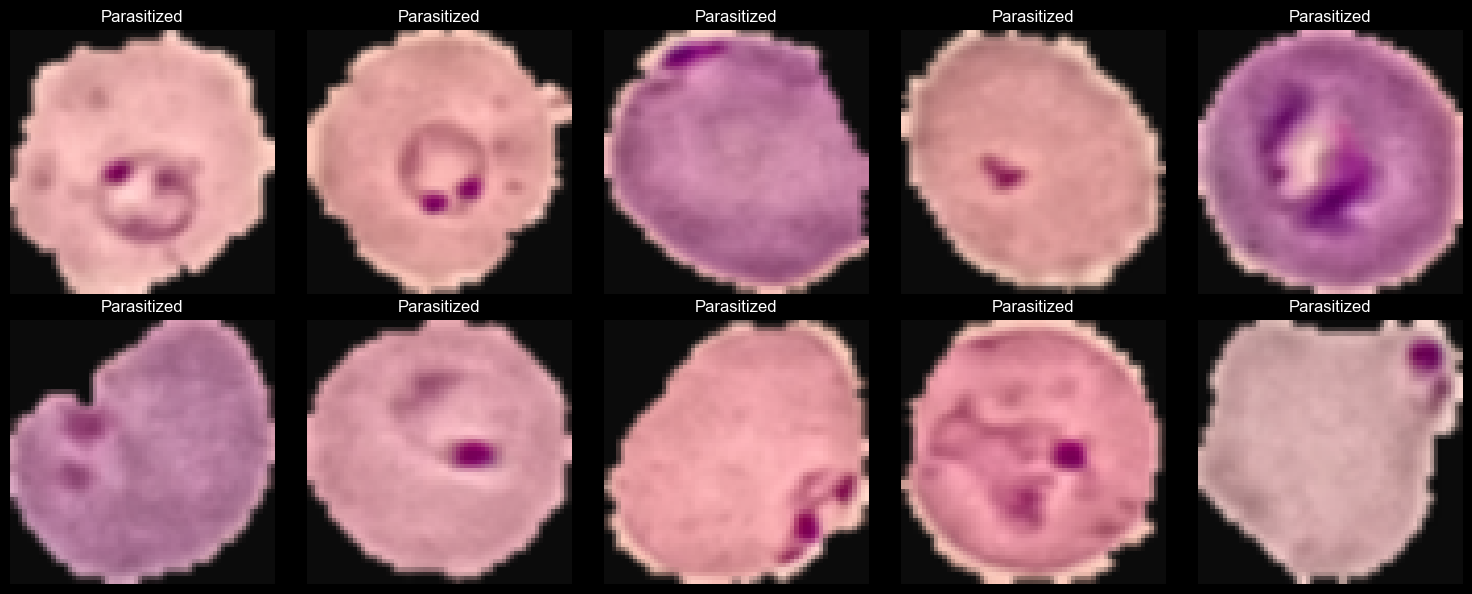

In [58]:
# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i * 200])
    ax.set_title(f"{classes[y[i * 200]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## 2. Feature Extraction and Data Preparation

In [59]:
# Flatten images for ML models
X_flattened = X.reshape(X.shape[0], -1)
print(f"Flattened shape: {X_flattened.shape}")

# Normalize pixel values
X_normalized = X_flattened / 255.0

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.1, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train labels distribution: {np.bincount(y_train)}")
print(f"Test labels distribution: {np.bincount(y_test)}")

Flattened shape: (4000, 12288)

Train set: (3600, 12288)
Test set: (400, 12288)
Train labels distribution: [1800 1800]
Test labels distribution: [200 200]


In [60]:
# Standardize features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data standardization complete!")

Data standardization complete!


## 3. Model 1: Logistic Regression Classifier

In [61]:
# Train Logistic Regression model
print("Training Logistic Regression model...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"\nLogistic Regression Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")

Training Logistic Regression model...

Logistic Regression Accuracy: 0.6725 (67.25%)


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

 Parasitized       0.68      0.66      0.67       200
  Uninfected       0.67      0.69      0.68       200

    accuracy                           0.67       400
   macro avg       0.67      0.67      0.67       400
weighted avg       0.67      0.67      0.67       400



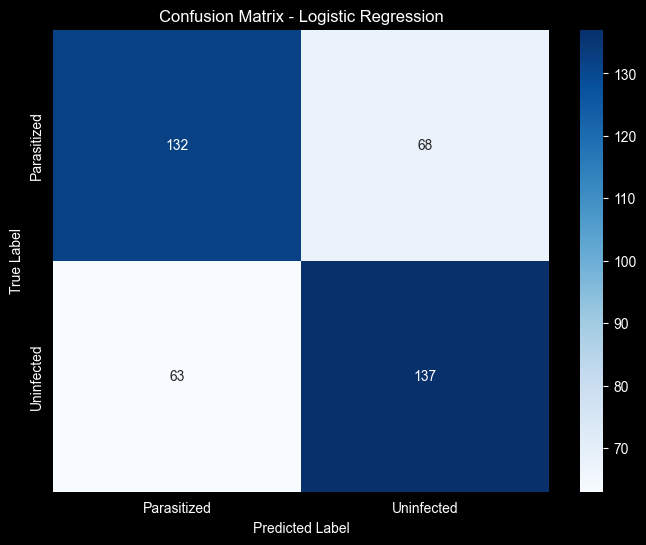

In [62]:
# Classification Report
print("Classification Report - Logistic Regression:")
print(classification_report(y_test, y_pred_lr, target_names=classes))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 4. Model 2: K-Means Clustering as Classifier

In [63]:
# Train K-Means model
print("Training K-Means clustering model...")
n_clusters = len(classes)
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300)
kmeans_model.fit(X_train_scaled)

# Predict clusters for test data
y_pred_kmeans_raw = kmeans_model.predict(X_test_scaled)

print(f"K-Means clustering complete with {n_clusters} clusters")

Training K-Means clustering model...
K-Means clustering complete with 2 clusters


In [64]:
# Map clusters to true labels (using majority voting)
def map_clusters_to_labels(y_true, y_pred, n_clusters):
    """Map cluster labels to true class labels using majority voting"""
    label_mapping = {}
    
    for cluster in range(n_clusters):
        # Find all samples in this cluster
        mask = (y_pred == cluster)
        if mask.sum() > 0:
            # Get the most common true label in this cluster
            labels_in_cluster = y_true[mask]
            most_common_label = np.bincount(labels_in_cluster).argmax()
            label_mapping[cluster] = most_common_label
    
    return label_mapping

# Get cluster mapping on training data
train_pred_kmeans = kmeans_model.predict(X_train_scaled)
cluster_mapping = map_clusters_to_labels(y_train, train_pred_kmeans, n_clusters)
print(f"Cluster to label mapping: {cluster_mapping}")

# Map test predictions to true labels
y_pred_kmeans = np.array([cluster_mapping[cluster] for cluster in y_pred_kmeans_raw])

# Calculate accuracy
kmeans_accuracy = accuracy_score(y_test, y_pred_kmeans)
print(f"\nK-Means Accuracy: {kmeans_accuracy:.4f} ({kmeans_accuracy*100:.2f}%)")

Cluster to label mapping: {0: np.int64(0), 1: np.int64(1)}

K-Means Accuracy: 0.6375 (63.75%)


Classification Report - K-Means:
              precision    recall  f1-score   support

 Parasitized       0.73      0.44      0.55       200
  Uninfected       0.60      0.83      0.70       200

    accuracy                           0.64       400
   macro avg       0.66      0.64      0.62       400
weighted avg       0.66      0.64      0.62       400



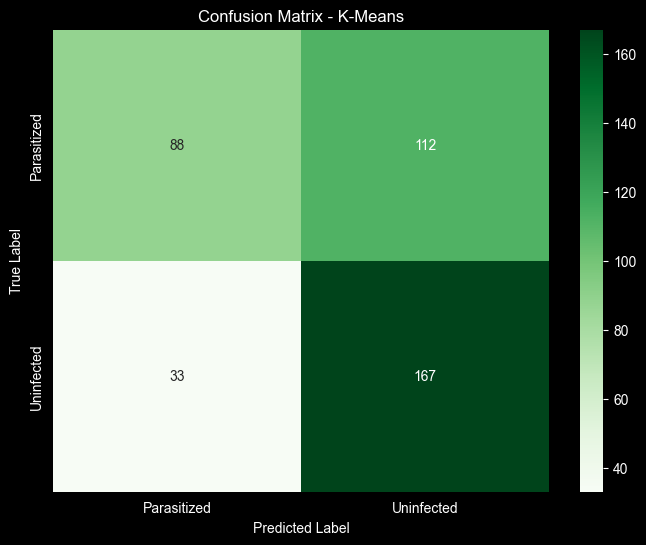

In [65]:
# Classification Report
print("Classification Report - K-Means:")
print(classification_report(y_test, y_pred_kmeans, target_names=classes))

# Confusion Matrix
cm_kmeans = confusion_matrix(y_test, y_pred_kmeans)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - K-Means')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 5. Model Comparison

Model Comparison:
              Model  Accuracy
Logistic Regression    0.6725
            K-Means    0.6375


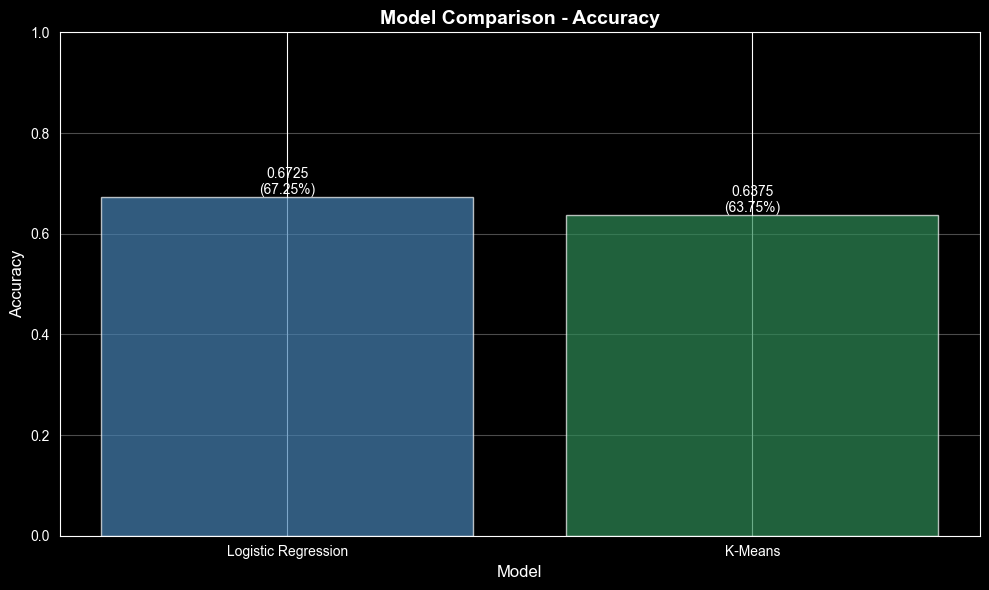

In [66]:
# Compare model accuracies
comparison_data = {
    'Model': ['Logistic Regression', 'K-Means'],
    'Accuracy': [lr_accuracy, kmeans_accuracy]
}

df_comparison = pd.DataFrame(comparison_data)
print("Model Comparison:")
print(df_comparison.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(df_comparison['Model'], df_comparison['Accuracy'], color=['steelblue', 'seagreen'], alpha=0.7)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.title('Model Comparison - Accuracy', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}\n({height*100:.2f}%)',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 6. Sample Predictions Visualization

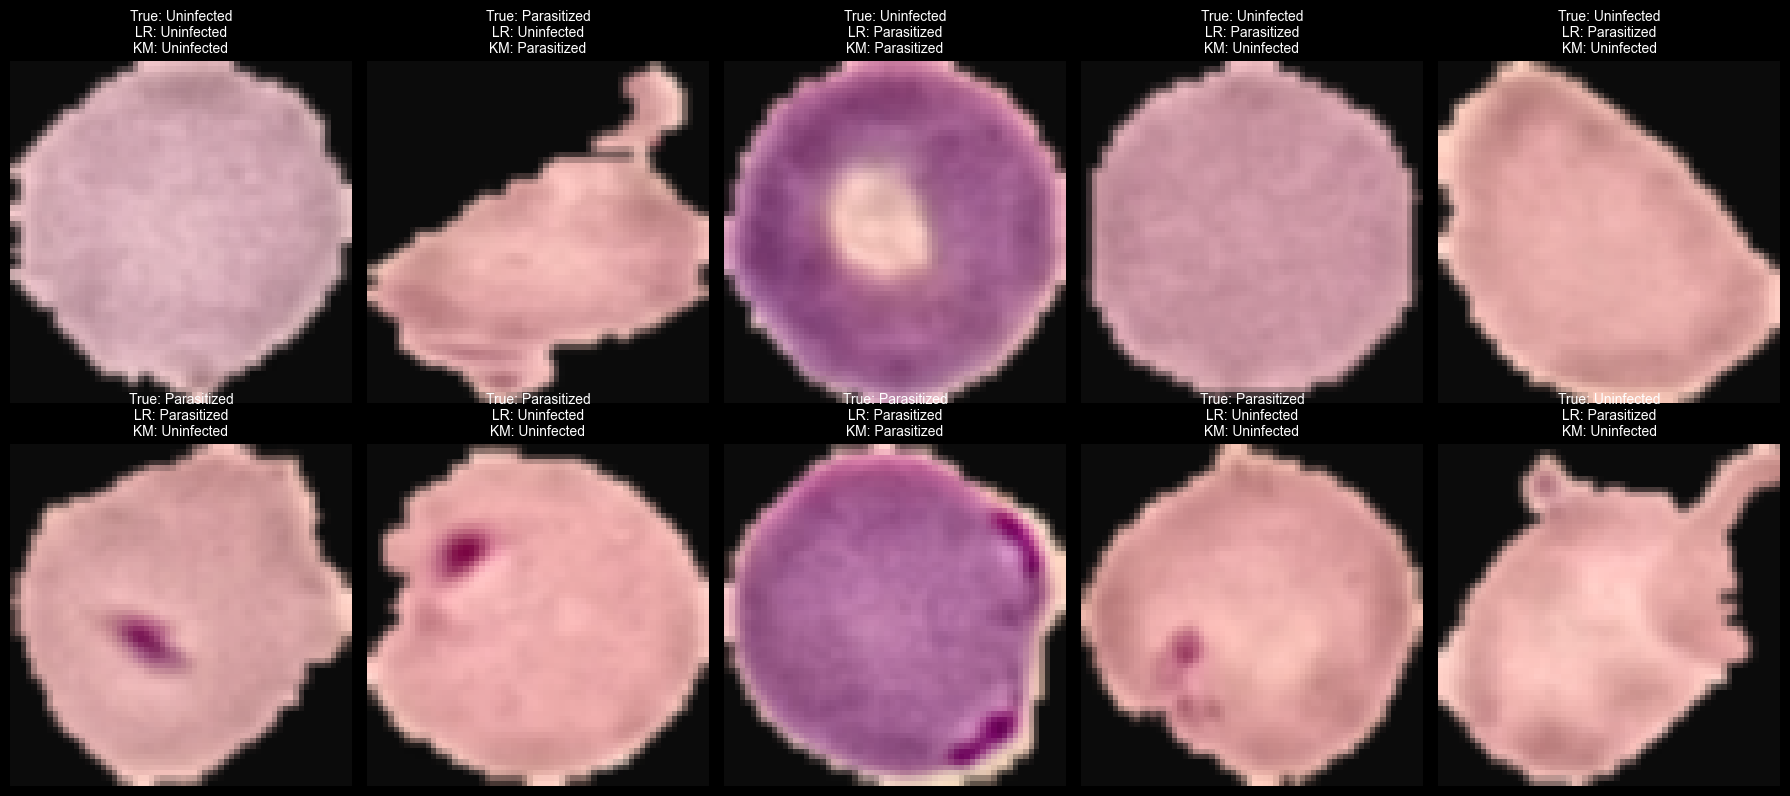

In [67]:
# Get indices for test samples
test_indices = np.arange(len(X_test))
sample_indices = np.random.choice(test_indices, 10, replace=False)

# Visualize predictions
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
for idx, ax in enumerate(axes.flat):
    sample_idx = sample_indices[idx]
    # Reshape back to image
    img = X_test[sample_idx].reshape(IMG_SIZE, IMG_SIZE, 3)
    
    true_label = classes[y_test[sample_idx]]
    lr_pred = classes[y_pred_lr[sample_idx]]
    km_pred = classes[y_pred_kmeans[sample_idx]]
    
    ax.imshow(img)
    ax.set_title(f'True: {true_label}\nLR: {lr_pred}\nKM: {km_pred}', fontsize=10)
    ax.axis('off')
    
    # Highlight incorrect predictions with red border
    if y_test[sample_idx] != y_pred_lr[sample_idx] or y_test[sample_idx] != y_pred_kmeans[sample_idx]:
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(3)

plt.tight_layout()
plt.show()

## 7. Summary and Conclusions

In [68]:
print("="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"\nDataset: Malaria Cell Images (Parasitized vs Uninfected)")
print(f"Total samples: {len(X)}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}x3")
print(f"Number of classes: {len(classes)}")
print(f"Classes: {', '.join(classes)}")
print(f"\nTrain/Test split: {len(X_train)}/{len(X_test)}")
print("\n" + "-"*60)
print("MODEL PERFORMANCE")
print("-"*60)
print(f"\n1. Logistic Regression:")
print(f"   - Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"   - Model Type: Supervised Classification")
print(f"\n2. K-Means Clustering:")
print(f"   - Accuracy: {kmeans_accuracy:.4f} ({kmeans_accuracy*100:.2f}%)")
print(f"   - Model Type: Unsupervised Clustering (as Classifier)")
print("\n" + "-"*60)
print(f"\nBest Model: {'Logistic Regression' if lr_accuracy > kmeans_accuracy else 'K-Means'}")
print(f"Accuracy Difference: {abs(lr_accuracy - kmeans_accuracy):.4f}")
print("="*60)

FINAL RESULTS SUMMARY

Dataset: Malaria Cell Images (Parasitized vs Uninfected)
Total samples: 4000
Image size: 64x64x3
Number of classes: 2
Classes: Parasitized, Uninfected

Train/Test split: 3600/400

------------------------------------------------------------
MODEL PERFORMANCE
------------------------------------------------------------

1. Logistic Regression:
   - Accuracy: 0.6725 (67.25%)
   - Model Type: Supervised Classification

2. K-Means Clustering:
   - Accuracy: 0.6375 (63.75%)
   - Model Type: Unsupervised Clustering (as Classifier)

------------------------------------------------------------

Best Model: Logistic Regression
Accuracy Difference: 0.0350
